In [1]:

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pandas  # used to load metadata table
import numpy as np
import sys
import lmfit as lmfit
import glob as glob



import numpy as np
import os
from Xana import Xana
from Xana.misc.makemask import masker
from matplotlib.colors import LogNorm


import pandas as pd
import pickle
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
from matplotlib import rc
import h5py
import os

from scipy import interpolate
import scipy.integrate as integrate

import matplotlib.pyplot as plt
import midtools



Functions for loading the files

In [2]:

def load_data_corrected(pathtodata,filenumbers, tmax,qrange):
    "function to load ttcs corrected with the ttc with stride 1, energy, positions"
    files=[]
    for run in filenumbers:
        os.chdir(pathtodata)
        for file in glob.glob(f"r{run:04d}*.h5"):
            files.append(file)
    files=sorted(files)

    f=h5py.File(pathtodata+files[0], 'r')
    
    ttcs=f['train_resolved/correlation/ttc'][:,0,qrange,:tmax,:tmax]-f['train_resolved/correlation/ttc'][:,1,qrange,:tmax,:tmax]+1
    positions =f['train_resolved/sample_position/y'][:,1]
    positionsz=f['train_resolved/sample_position/y'][:,2]
    energy=f['pulse_resolved/xgm/energy'][:,:tmax]
    qvalues=f['train_resolved/correlation/q'][qrange]

    for filename in files[1:]:
        try:
            f=h5py.File(pathtodata+filename, 'r')
            ttcs=np.append(ttcs, f['train_resolved/correlation/ttc'][:,0,qrange,:tmax,:tmax]-f['train_resolved/correlation/ttc'][:,1,qrange,:tmax,:tmax]+1, axis=0)
            energy=np.append(energy,f['pulse_resolved/xgm/energy'][:,:tmax], axis=0)
            positions =np.append(positions,f['train_resolved/sample_position/y'][:,1])
            positionsz=np.append(positionsz,f['train_resolved/sample_position/y'][:,2])
            #average_intensity=np.append(average_intensity,f['average/image_2d'][:])
            print(f'loaded {filename}')
        except KeyError:
            print(f'ttc of {filename} not found')
        except FileNotFoundError:
            print(f'file {filename} not found')
    
    return(ttcs,qvalues,positions,positionsz,energy)#positionsz,energy,t_delay,


def load_saxs(pathtodata,filenames):
    "Function to load saxs, average 2d image, energy and sample position"
    f=h5py.File(pathtodata+filenames[0], 'r')
    I=f['pulse_resolved/azimuthal_intensity/I'][:]
    q=f['pulse_resolved/azimuthal_intensity/q'][:]
    positions =f['train_resolved/sample_position/y'][:,1]
    positionsz=f['train_resolved/sample_position/y'][:,2]
    energy=f['pulse_resolved/xgm/energy'][:,:tmax]
    average_intensity=f['average/intensity'][:]

    for filename in filenames[1:]:
        f=h5py.File(pathtodata+filename, 'r')
        I=np.append(I, f['pulse_resolved/azimuthal_intensity/I'][:], axis=0)
        energy=np.append(energy,f['pulse_resolved/xgm/energy'][:,:tmax], axis=0)
        positions =np.append(positions,f['train_resolved/sample_position/y'][:,1])
        positionsz=np.append(positionsz,f['train_resolved/sample_position/y'][:,2])
        average_intensity=np.append(average_intensity,f['average/intensity'][:])


    return(q,I,average_intensity,positions,positionsz,energy)#t_delay,


Functions for masking and correcting ttcs 

In [3]:
def put_mask_ttc(ttcs):

    problematic_pixel=30
    problematic_pixel2=62
    problematic_pixel3=94

    ttcs[:,:,problematic_pixel,:problematic_pixel]=np.nan
    ttcs[:,:,:problematic_pixel,problematic_pixel]=np.nan
    ttcs[:,:,problematic_pixel+1,problematic_pixel+1:]=np.nan
    ttcs[:,:,problematic_pixel+1:,problematic_pixel+1]=np.nan

    ttcs[:,:,problematic_pixel2,:problematic_pixel2]=np.nan
    ttcs[:,:,:problematic_pixel2,problematic_pixel2]=np.nan
    ttcs[:,:,problematic_pixel2+1,problematic_pixel2+1:]=np.nan
    ttcs[:,:,problematic_pixel2+1:,problematic_pixel2+1]=np.nan

    ttcs[:,:,problematic_pixel3,:]=np.nan
    ttcs[:,:,:,problematic_pixel3]=np.nan
    return(ttcs)



    
def ttc_baseline_correction(ave_ttc,err_ttc):
    baseline_corrected_ttc=[]

    cut_pixel=20
    problematic_pixel=30
    problematic_pixel2=62
    problematic_pixel3=94

    ttc_turned_lq=np.zeros([100,100])*np.nan
    ttc_turned_mq=np.zeros([100,100])*np.nan
    ttc_turned_hq=np.zeros([100,100])*np.nan

    ttc_turned_rest=np.zeros([100,100])*np.nan


    err_ttc_turned_lq=np.zeros([100,100])*np.nan
    err_ttc_turned_mq=np.zeros([100,100])*np.nan
    err_ttc_turned_hq=np.zeros([100,100])*np.nan

    err_ttc_turned_rest=np.zeros([100,100])*np.nan

    for i in range(problematic_pixel):
        ttc_turned_lq[i,:len(ave_ttc[i,i:problematic_pixel])]=ave_ttc[i,i:problematic_pixel]
        err_ttc_turned_lq[i,:len(ave_ttc[i,i:problematic_pixel])]=err_ttc[i,i:problematic_pixel]
    
    for i in range(problematic_pixel+1,problematic_pixel2):
        ttc_turned_mq[i,:len(ave_ttc[i,i:problematic_pixel2])]=ave_ttc[i,i:problematic_pixel2]
        err_ttc_turned_mq[i,:len(ave_ttc[i,i:problematic_pixel2])]=err_ttc[i,i:problematic_pixel2]


    for i in range(problematic_pixel2+1,problematic_pixel3):
        ttc_turned_hq[i,:len(ave_ttc[i,i:problematic_pixel3])]=ave_ttc[i,i:problematic_pixel3]
        err_ttc_turned_hq[i,:len(ave_ttc[i,i:problematic_pixel3])]=err_ttc[i,i:problematic_pixel3]


    for i in range(problematic_pixel):
        ttc_turned_rest[i,problematic_pixel-i:-i+problematic_pixel+len(ave_ttc[i,problematic_pixel:])]=ave_ttc[i,problematic_pixel:]
        err_ttc_turned_rest[i,problematic_pixel-i:-i+problematic_pixel+len(ave_ttc[i,problematic_pixel:])]=err_ttc[i,problematic_pixel:]
    for i in range(problematic_pixel+1,problematic_pixel2):
        ttc_turned_rest[i,-i+problematic_pixel2:-i+problematic_pixel2+len(ave_ttc[i,problematic_pixel2:])]=ave_ttc[i,problematic_pixel2:]
        err_ttc_turned_rest[i,-i+problematic_pixel2:-i+problematic_pixel2+len(ave_ttc[i,problematic_pixel2:])]=err_ttc[i,problematic_pixel2:]
    for i in range(problematic_pixel2+1,problematic_pixel3):
        ttc_turned_rest[i,-i+problematic_pixel3:-i+problematic_pixel3+len(ave_ttc[i,problematic_pixel3:])]=ave_ttc[i,problematic_pixel3:]
        err_ttc_turned_rest[i,-i+problematic_pixel3:-i+problematic_pixel3+len(ave_ttc[i,problematic_pixel3:])]=err_ttc[i,problematic_pixel3:]


    w_lq=1/err_ttc_turned_lq**2
    w_mq=1/err_ttc_turned_mq**2
    w_hq=1/err_ttc_turned_hq**2
    w_rest=1/err_ttc_turned_rest**2

    baseline_lowerquadrant=np.nansum(ttc_turned_lq[:,cut_pixel:problematic_pixel]*w_lq[:,cut_pixel:problematic_pixel])/np.nansum(w_lq[:,cut_pixel:problematic_pixel])
    baseline_middlequadrant=np.nansum(ttc_turned_mq[:,cut_pixel:problematic_pixel]*w_mq[:,cut_pixel:problematic_pixel])/np.nansum(w_mq[:,cut_pixel:problematic_pixel])
    baseline_upperquadrant=np.nansum(ttc_turned_hq[:,cut_pixel:problematic_pixel]*w_hq[:,cut_pixel:problematic_pixel])/np.nansum(w_hq[:,cut_pixel:problematic_pixel])
    baseline_remaining=np.nansum(ttc_turned_rest[:,cut_pixel:problematic_pixel]*w_rest[:,cut_pixel:problematic_pixel])/np.nansum(w_rest[:,cut_pixel:problematic_pixel])

   
    baseline_corrected_ttc=ave_ttc.copy()
    baseline_corrected_ttc[:problematic_pixel,:problematic_pixel]+=-baseline_lowerquadrant+baseline_remaining
    baseline_corrected_ttc[problematic_pixel+1:problematic_pixel2,problematic_pixel+1:problematic_pixel2]+= -baseline_middlequadrant+baseline_remaining
    baseline_corrected_ttc[problematic_pixel2+1:problematic_pixel3,problematic_pixel2+1:problematic_pixel3]+= -baseline_upperquadrant+baseline_remaining

    baseline_corrected_ttc[problematic_pixel,:problematic_pixel]=np.nan
    baseline_corrected_ttc[:problematic_pixel,problematic_pixel]=np.nan
    baseline_corrected_ttc[problematic_pixel+1,problematic_pixel+1:]=np.nan
    baseline_corrected_ttc[problematic_pixel+1:,problematic_pixel+1]=np.nan
    

    baseline_corrected_ttc[problematic_pixel2,:problematic_pixel2]=np.nan
    baseline_corrected_ttc[:problematic_pixel2,problematic_pixel2]=np.nan
    baseline_corrected_ttc[problematic_pixel2+1,problematic_pixel2+1:]=np.nan
    baseline_corrected_ttc[problematic_pixel2+1:,problematic_pixel2+1]=np.nan

    baseline_corrected_ttc[problematic_pixel3,:]=np.nan
    baseline_corrected_ttc[:,problematic_pixel3]=np.nan

    for i in range(np.size(ave_ttc,0)):
        baseline_corrected_ttc[i,i]=ave_ttc[i,i]
    
    #baseline_corrected_ttc=baseline_corrected_ttc/np.nanmean(baseline_corrected_ttc[80:,:5])
    return(baseline_corrected_ttc)

In [18]:
pathtodata='/gpfs/exfel/u/scratch/MID/202202/p003094/Anita/analyzed_runs_photonised_ADU8p9/p003094/'
proposal = 3094


filenames_1_60mgml_23C=np.arange(115,134)
filenames_1_60mgml_0C=np.arange(177,189)
filenames_1_60mgml_m20C=np.arange(213,224)

filenames_2_60mgml_23C=np.arange(127,134)
filenames_2_60mgml_0C=np.arange(189,201)
filenames_2_60mgml_m20C=np.arange(201,213)

filenames_10_60mgml_23C=np.arange(136,140)



filenames_2_70mgml=[77,78]
filenames_1_70mgml=[58,60,63,65]
filenames_p6_70mgml=np.arange(70,77)

filenames_10_15mgml=[263,264]
filenames_2_15mgml=np.arange(259,265)
filenames_1_15mgml=np.arange(255,259)
filenames_p6_15mgml=np.arange(249,255)


filenames_4=[98,99]
filenames_2=[79,80]
filenames_1=np.arange(81,85)
filenames_p6=[85,86]+list(np.arange(89,97))

vycor=[107]

si100nm=[104,105,111,112,113,114]
si20nm=[57]


tmax=100
t_delay=.44
qrange=np.arange(15)

In [38]:
ttcs,qvalues,positions,positionsz,energy=load_data_corrected(pathtodata,filenames_1_60mgml_23C,tmax,qrange)
print(r'data loaded')




loaded r0115-analysis_002.h5
loaded r0115-analysis_003.h5
loaded r0116-analysis_000.h5
loaded r0116-analysis_001.h5
ttc of r0116-analysis_002.h5 not found
loaded r0117-analysis_001.h5
loaded r0117-analysis_002.h5
ttc of r0117-analysis_003.h5 not found
loaded r0118-analysis_001.h5
loaded r0118-analysis_002.h5
loaded r0118-analysis_003.h5
loaded r0119-analysis_000.h5
loaded r0119-analysis_002.h5
loaded r0119-analysis_003.h5
loaded r0120-analysis_000.h5
loaded r0120-analysis_002.h5
loaded r0120-analysis_003.h5
loaded r0121-analysis_000.h5
loaded r0121-analysis_002.h5
loaded r0121-analysis_003.h5
loaded r0122-analysis_000.h5
loaded r0122-analysis_001.h5
loaded r0123-analysis_001.h5
loaded r0123-analysis_002.h5
loaded r0123-analysis_003.h5
loaded r0124-analysis_000.h5
loaded r0124-analysis_001.h5
loaded r0124-analysis_002.h5
loaded r0125-analysis_000.h5
loaded r0125-analysis_002.h5
loaded r0126-analysis_002.h5
loaded r0126-analysis_003.h5
loaded r0126-analysis_006.h5
loaded r0127-analysis_0

In [24]:
ttcs=put_mask_ttc(ttcs)
np.shape(ttcs)

(33462, 15, 100, 100)

Filters for position and energy

18218
std threshold value: 1.02465


Text(0, 0.5, 'sample position y (mm)')

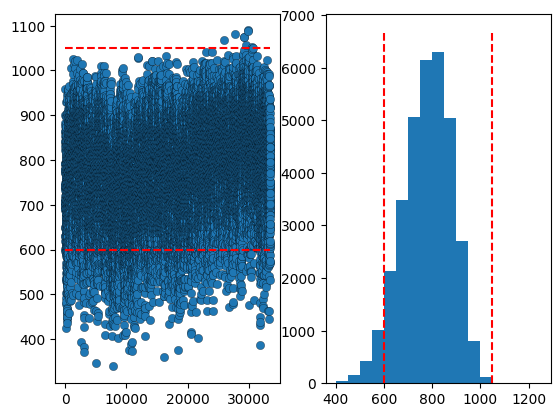

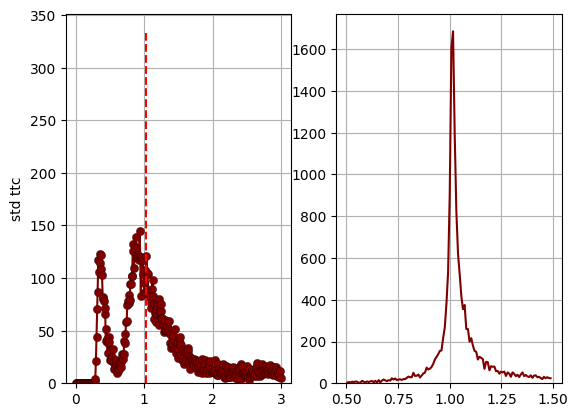

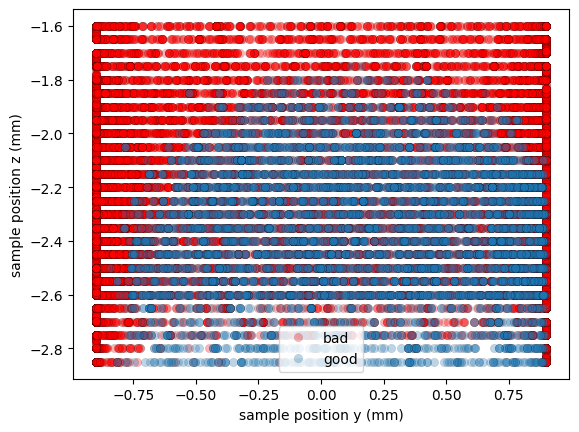

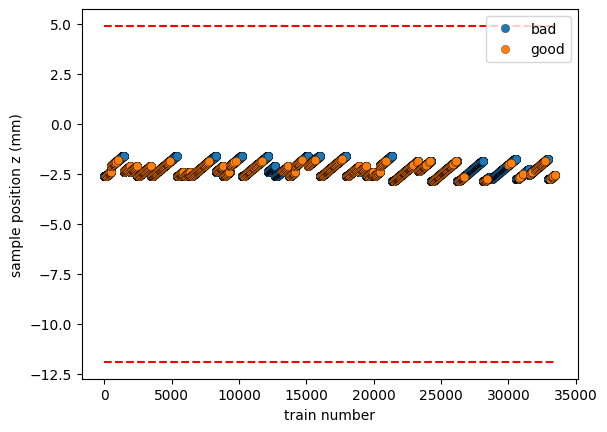

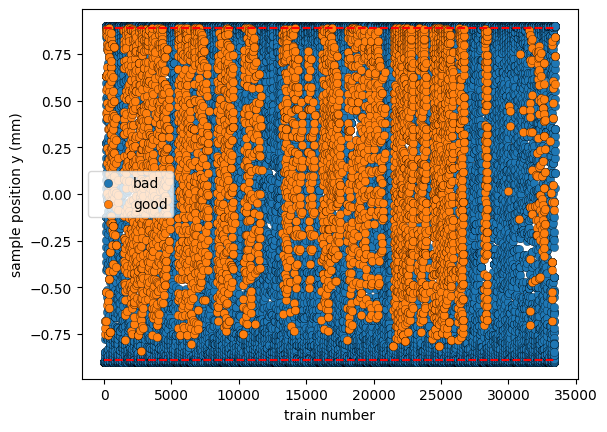

In [29]:

qnum=len(qvalues)
qmin=0
qmax=qnum
colore=plt.cm.jet(np.linspace(0,1,qmax-qmin))
q=1
train_number=np.arange(len(positions))
tminframes=0
totframes=100
tmaxframes=100
tmax_mean=100



bins_std=np.arange(0,3,0.009)
bins_mean=np.arange(.5,1.5,0.008)
## ENERGY #######################################

mean_energy=np.mean(energy[:,:10],1)
min_energy=600
max_energy=1050


plt.figure()
plt.subplot(1,2,1)
plt.plot(mean_energy,marker='o',ls=' ',markeredgewidth=.2,markeredgecolor='black')
plt.hlines(min_energy,0, len(mean_energy),color='red',ls='dashed')
plt.hlines(max_energy,0, len(mean_energy),color='red',ls='dashed')

plt.subplot(1,2,2)
n_energy,x,_ =plt.hist(mean_energy,np.arange(400,1300,50))
bin_centers_energy = 0.5*(x[1:]+x[:-1])
plt.vlines(min_energy,0, len(mean_energy)/5,color='red',ls='dashed')
plt.vlines(max_energy,0, len(mean_energy)/5,color='red',ls='dashed')

filtering_energy=(mean_energy>min_energy)&(mean_energy<max_energy)

## POSITION #######################################

minpositionz=-11.9
maxpositionz=4.9
minposition=-.89
maxposition=.89

filtering_positions=(positions<maxposition)&(positions>minposition)#&(positionsz<maxpositionz)&(positionsz>minpositionz)
print(sum(filtering_positions&filtering_energy))

## std and mean #######################################
value_mean = np.nanmean(ttcs[:,q,tminframes:tmax_mean,tminframes:tmax_mean],axis=(1,2))
value_std  = np.nanstd(ttcs[:,q,tminframes:tmax_mean,tminframes:tmax_mean],axis=(1,2))

plt.figure()
##  mean #######################################
minttcmean=.8
maxttcmean=1.2

plt.subplot(1,2,2)
n_mean,x,_ = plt.hist(value_mean[filtering_energy&filtering_positions],bins_mean,alpha=0,color=colore[i])
bin_centers_mean = 0.5*(x[1:]+x[:-1])
plt.plot(bin_centers_mean,n_mean,color=colore[i],markeredgewidth=.2,markeredgecolor='black')
plt.grid('on')
plt.ylabel('mean ttc')

## std #######################################
plt.subplot(1,2,1)
n_std,x,_ = plt.hist(value_std[filtering_energy&filtering_positions],bins_std,alpha=0,color=colore[i])
bin_centers_std = 0.5*(x[1:]+x[:-1])
plt.plot(bin_centers_std,n_std,color=colore[i],marker='o',markeredgewidth=.2,markeredgecolor='black')
plt.ylabel('std ttc')
plt.grid('on')

high_std_threshold=bin_centers_std[n_std==max(n_std)]+(bin_centers_std[n_std==max(n_std)])*.1

plt.vlines(high_std_threshold[0],0, len(value_std)/100,color='red',ls='dashed')
print(f'std threshold value: {high_std_threshold[0]}')

filtering_mean=(value_mean>minttcmean)&(value_mean<maxttcmean)
filtering_std=(value_std<high_std_threshold[0])
#filtering_ratio=((value_mean-1)/value_std>.15)&((value_mean-1)/value_std<.4)

good_trains=filtering_positions&filtering_energy&filtering_std&filtering_mean

## Plot POSITION #######################################


plt.figure()
plt.plot(positions[~good_trains],positionsz[~good_trains],marker='o',ls=' ',markeredgewidth=.2,markeredgecolor='black',color='red',alpha=0.3)
plt.plot(positions[good_trains],positionsz[good_trains],marker='o',ls=' ',markeredgewidth=.2,markeredgecolor='black',alpha=0.3)
plt.legend(['bad','good'])
plt.xlabel('sample position y (mm)')
plt.ylabel('sample position z (mm)')


plt.figure()
plt.plot(train_number[~good_trains],positionsz[~good_trains],marker='o',ls=' ',markeredgewidth=.2,markeredgecolor='black')
plt.plot(train_number[good_trains],positionsz[good_trains],marker='o',ls=' ',markeredgewidth=.2,markeredgecolor='black')
plt.hlines(minpositionz,0, len(positions),color='red',ls='dashed')
plt.hlines(maxpositionz,0, len(positions),color='red',ls='dashed')
plt.legend(['bad','good'])
plt.xlabel('train number')
plt.ylabel('sample position z (mm)')

plt.figure()
plt.plot(train_number[~good_trains],positions[~good_trains],marker='o',ls=' ',markeredgewidth=.2,markeredgecolor='black')
plt.plot(train_number[good_trains],positions[good_trains],marker='o',ls=' ',markeredgewidth=.2,markeredgecolor='black')

plt.hlines(minposition,0, len(positions),color='red',ls='dashed')
plt.hlines(maxposition,0, len(positions),color='red',ls='dashed')
plt.legend(['bad','good'])
plt.xlabel('train number')
plt.ylabel('sample position y (mm)')


Calculation of ttc applying filter on position, energy, standard deviation in one ttc, mean of a ttc

q=0
std threshold value: 1.46835
number of averaged files: 6106


/tmp/ipykernel_36886/3355234804.py:84: RuntimeWarning: Mean of empty slice
  ave_ttc=np.nanmean(ttcs[good_trains,q,:totframes,:totframes],axis=0)


q=1
std threshold value: 1.21095
number of averaged files: 7292
q=2
std threshold value: 1.09395
number of averaged files: 7347
q=3
std threshold value: 0.97695
number of averaged files: 7581
q=4
std threshold value: 0.93015
number of averaged files: 4336
q=5
std threshold value: 0.73125
number of averaged files: 7453
q=6
std threshold value: 0.70785
number of averaged files: 7352
q=7
std threshold value: 0.78975
number of averaged files: 7811
q=8
std threshold value: 0.90675
number of averaged files: 7961
q=9
std threshold value: 0.40365
number of averaged files: 1448
q=10
std threshold value: 0.41535
number of averaged files: 1071
q=11
std threshold value: 1.1758499999999998
number of averaged files: 5983
q=12
std threshold value: 0.5674499999999999
number of averaged files: 1494
q=13
std threshold value: 0.70785
number of averaged files: 1423
q=14
std threshold value: 0.8482499999999998
number of averaged files: 1500


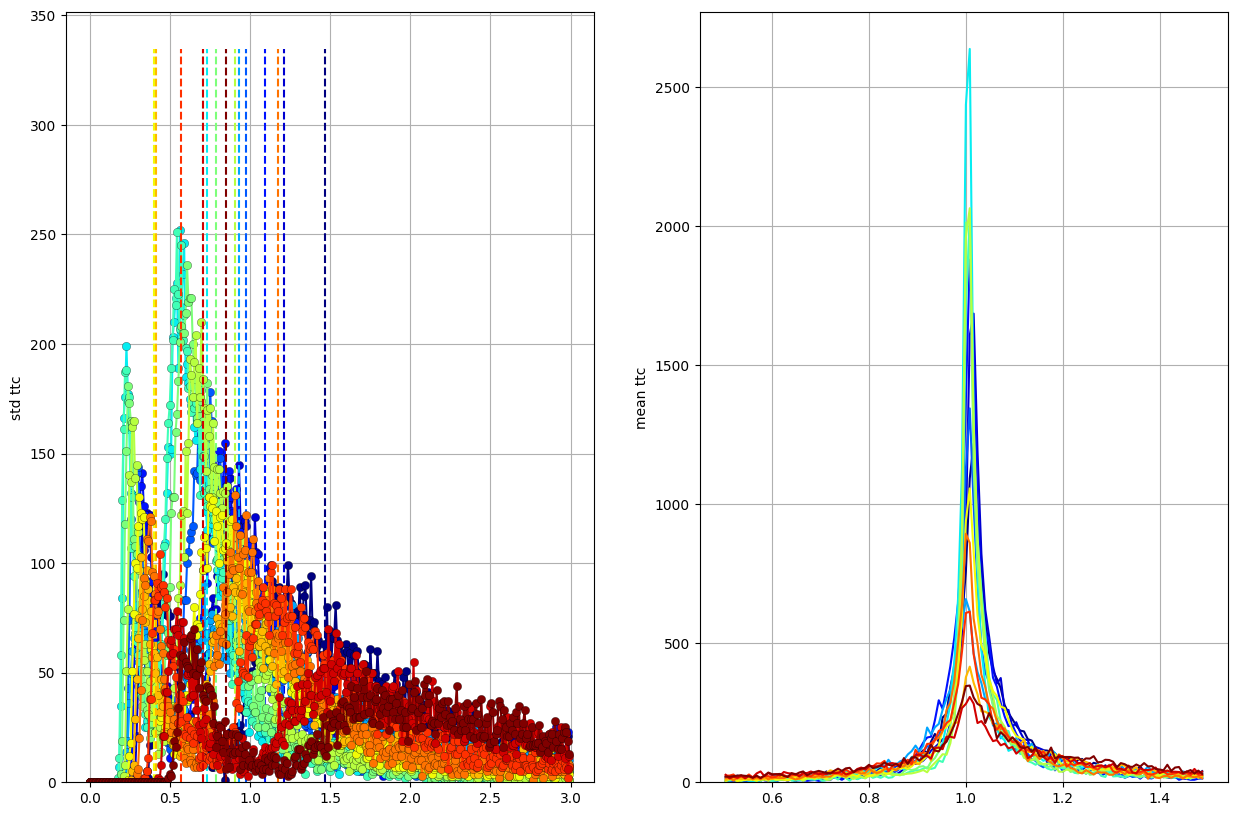

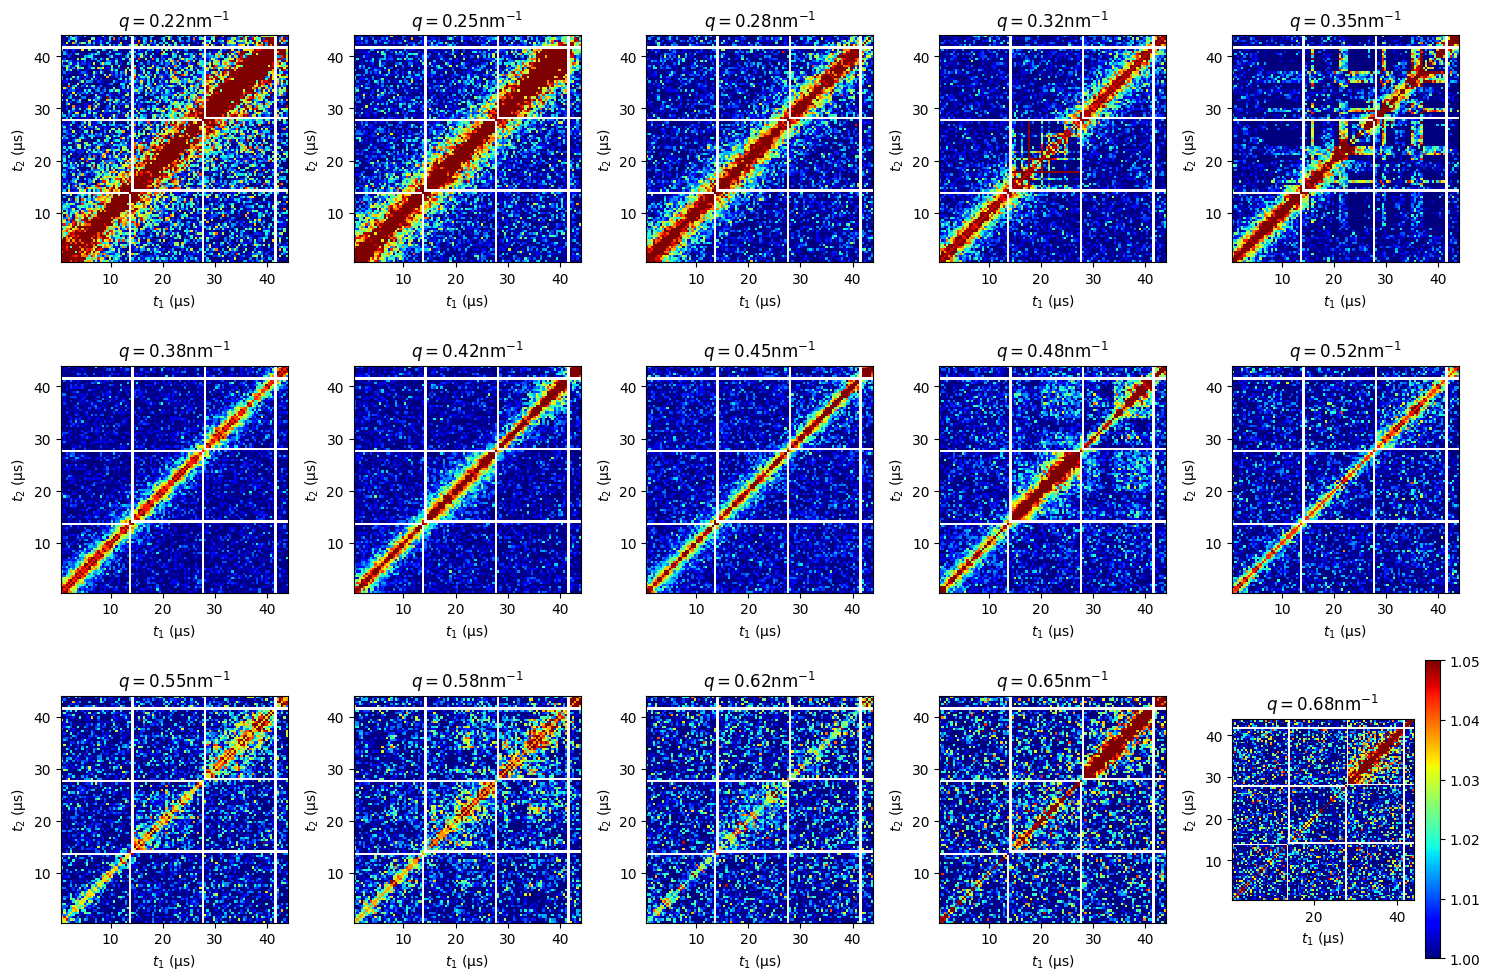

In [36]:

qnum=len(qvalues)
qmin=0
qmax=qnum
colore=plt.cm.jet(np.linspace(0,1,qmax-qmin))


t_new=np.arange(1000)*.1

tminframes=0
totframes=100
tmaxframes=100
tmax_mean=100


t=np.arange(1,tmaxframes-tminframes)*t_delay


fig2=plt.figure(figsize=(15,10))
fig1=plt.figure(figsize=(15,10))

allg2=[]
alldg2=[]

all_ttcs=np.zeros([qmax-qmin,totframes,totframes])
all_err_ttcs=np.zeros([qmax-qmin,totframes,totframes])

bins_std=np.arange(0,3,0.009)
bins_mean=np.arange(.5,1.5,0.008)

n_std_all=np.zeros([qmax-qmin,len(bins_std)-1])
n_mean_all=np.zeros([qmax-qmin,len(bins_mean)-1])
high_std_threshold_all=np.zeros([qmax-qmin])

n_tot_files=np.zeros([qmax-qmin])

for i,q in enumerate(range(qmin,qmax)):
    print(f'q={q}')
    #value_mean = np.average(ttcs[:,q,:totframes,:totframes],axis=(1,2))#np.average(ttcs_raw[:,stride,q,:totframes,:totframes],axis=(1,2))
    value_mean = np.nanmean(ttcs[:,q,tminframes:tmax_mean,tminframes:tmax_mean],axis=(1,2))
    value_std  = np.nanstd(ttcs[:,q,tminframes:tmax_mean,tminframes:tmax_mean],axis=(1,2))
    

    plt.figure(fig1)


    plt.subplot(1,2,2)
    n_mean,x,_ = plt.hist(value_mean[filtering_energy&filtering_positions],bins_mean,alpha=0,color=colore[i])
    bin_centers_mean = 0.5*(x[1:]+x[:-1])
    plt.plot(bin_centers_mean,n_mean,color=colore[i],markeredgewidth=.2,markeredgecolor='black')
    plt.grid('on')
    plt.ylabel('mean ttc')



    plt.subplot(1,2,1)
    n_std,x,_ = plt.hist(value_std[filtering_energy&filtering_positions],bins_std,alpha=0,color=colore[i])
    bin_centers_std = 0.5*(x[1:]+x[:-1])
    plt.plot(bin_centers_std,n_std,color=colore[i],marker='o',markeredgewidth=.2,markeredgecolor='black')
    plt.ylabel('std ttc')
    
    plt.grid('on')


    #low_ttc_threshold=bin_centers_mean[n_mean==max(n_mean)]-(bin_centers_mean[n_mean==max(n_mean)]-1)*.3
    #high_ttc_threshold=bin_centers_mean[n_mean==max(n_mean)]+(bin_centers_mean[n_mean==max(n_mean)]-1)*.3
    high_std_threshold=bin_centers_std[n_std==max(n_std)]+(bin_centers_std[n_std==max(n_std)])*.3
    high_std_threshold_all[q]=high_std_threshold[0]
    plt.vlines( high_std_threshold_all[q],0, len(value_std)/100,color=colore[i],ls='dashed')
    print(f'std threshold value: {high_std_threshold[0]}')
    # ''

    n_std_all[q,:]=n_std
    n_mean_all[q,:]=n_mean

    filtering_mean=(value_mean>minttcmean)&(value_mean<maxttcmean)
    filtering_std=(value_std<high_std_threshold[0])
    #filtering_ratio=((value_mean-1)/value_std>.15)&((value_mean-1)/value_std<.4)
    
    good_trains=filtering_positions&filtering_energy&filtering_mean&filtering_std
    print(f'number of averaged files: {sum(good_trains)}')
    n_tot_files=sum(good_trains)


    ave_ttc=np.nanmean(ttcs[good_trains,q,:totframes,:totframes],axis=0)
    err_ttc=np.nanstd(ttcs[good_trains,q,:totframes,:totframes],axis=0)/np.sqrt(sum(good_trains))
    ave_ttc_baselinecorrected=ttc_baseline_correction(ave_ttc,err_ttc) 

    all_ttcs[q,:,:]=ave_ttc_baselinecorrected
    all_err_ttcs[q,:,:]=err_ttc

    plt.figure(fig2)
    plt.subplot(3,5,q-qmin+1)

    plt.imshow(ave_ttc_baselinecorrected,origin='lower',cmap='jet',
        vmin=1,vmax=1.05,extent=(t_delay,t_delay*totframes,t_delay,t_delay*totframes),interpolation='none')
    plt.title('$q=$'+str(np.round(qvalues[q],2))+'nm$^{-1}$')
    
    if q==qmax-1:
        plt.colorbar()
    plt.tight_layout()
    plt.ylabel('$t_2$ (μs)')
    plt.xlabel('$t_1$ (μs)')
    
    
    
    #g2,dg2=calculate_g2(ave_ttc_baselinecorrected[tminframes:tmaxframes,tminframes:tmaxframes])
 
    #allg2.append(g2)
    #
    # alldg2.append(dg2)



In [37]:
namefile='c_60_abs1_23C_errorbars'

np.savez(f'{pathtodata}{namefile}.npz',
    ttcs=all_ttcs,
    err_ttcs=all_err_ttcs,
    q=qvalues,
    
    bin_centers_std=bin_centers_std,
    n_std_all=n_std_all,
    high_std_threshold_all=high_std_threshold_all,
    
    bin_centers_mean=bin_centers_mean,
    n_mean_all=n_mean_all,
    minttcmean=minttcmean,
    maxttcmean=maxttcmean,
    
    bin_centers_energy=bin_centers_energy,
    n_energy=n_energy,
    min_energy=min_energy,
    max_energy=max_energy,

    maxposition=maxposition,
    minposition=minposition,

    maxpositionz=maxpositionz,
    minpositionz=minpositionz,

    position_filter='z',

    n_tot_files=n_tot_files,

                 )

# To check the function to correct the ttcs

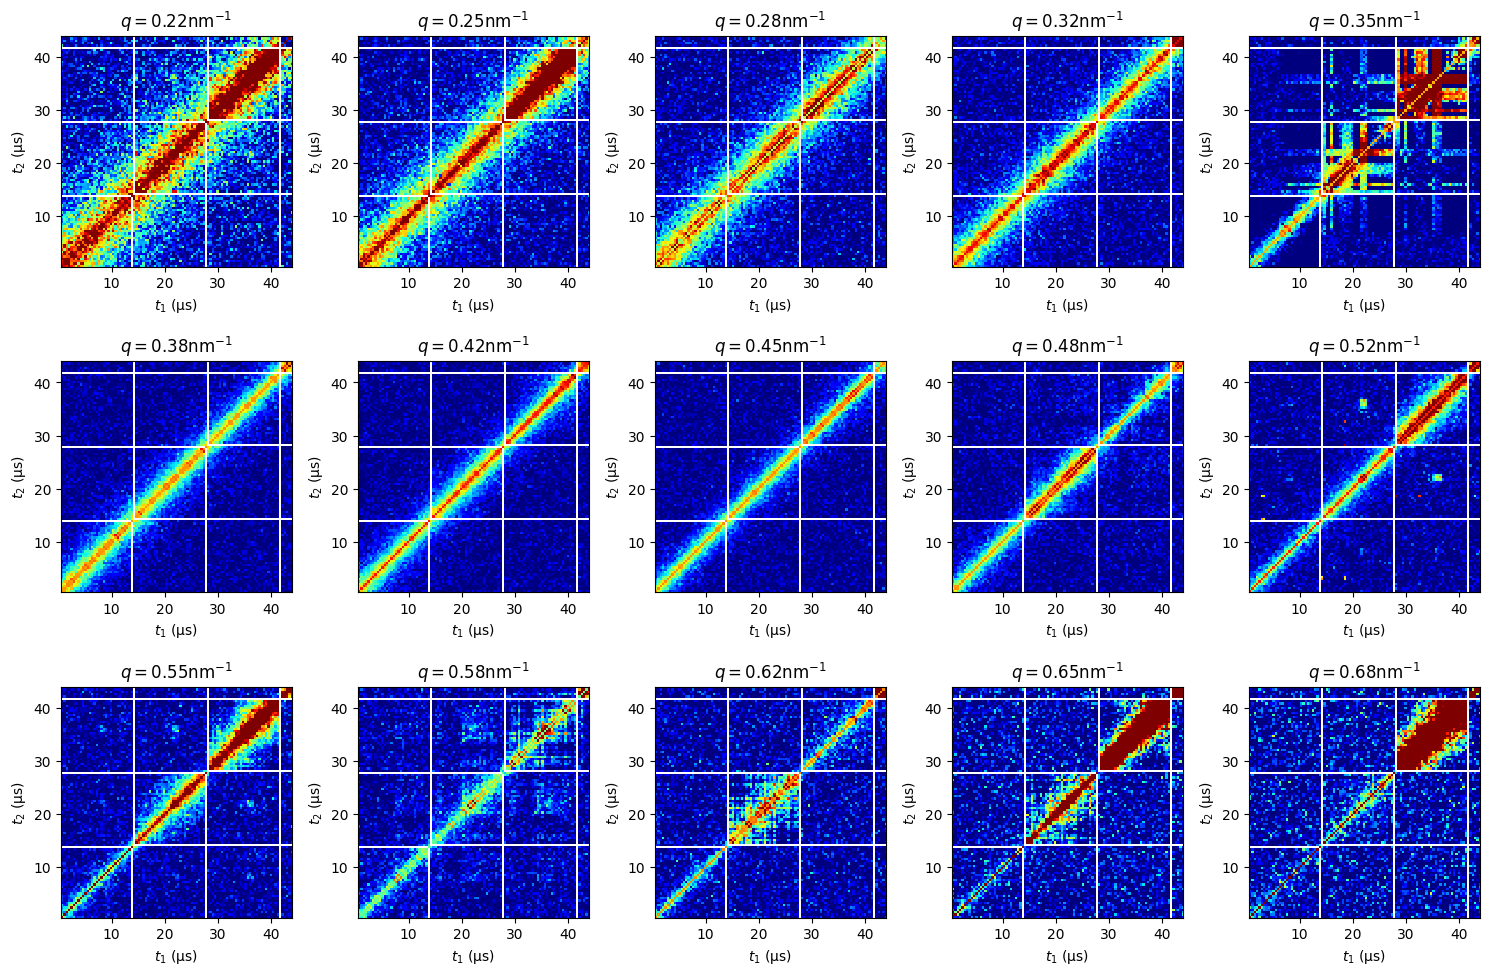

In [76]:
tot_frames=100
fig=plt.figure(figsize=(15,10))
for q in range(15):
   

    plt.subplot(3,5,q+1)
    plt.imshow(all_ttcs[q,:,:],origin='lower',cmap='jet',vmin=1,vmax=1.05,extent=(t_delay,t_delay*tot_frames,t_delay,t_delay*tot_frames,),interpolation='none')
    plt.title('$q=$'+str(np.round(qvalues[q],2))+'nm$^{-1}$')
    plt.tight_layout()
    plt.ylabel('$t_2$ (μs)')
    plt.xlabel('$t_1$ (μs)')

    if i==len(namefile)-1:
        plt.colorbar()

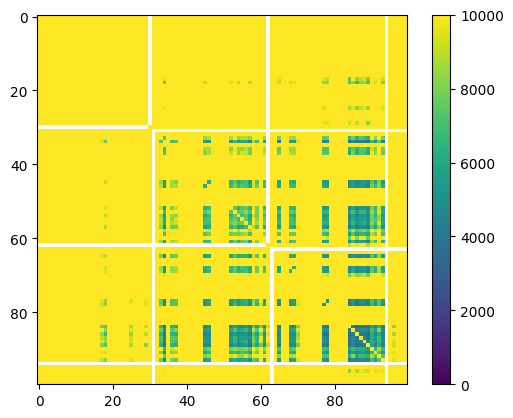

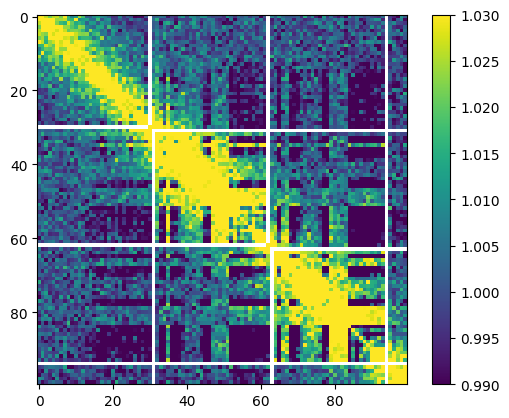

In [34]:
q=4
plt.figure()

plt.imshow(all_ttcs[q,:,:]/all_err_ttcs[q,:,:]**2,vmin=0,vmax=10000 )
plt.colorbar()

plt.figure()
plt.imshow(all_ttcs[q,:,:],vmin=.99,vmax=1.03)
plt.colorbar()



In [130]:
ttc_turned_lq=np.zeros([100,100])*np.nan
ttc_turned_mq=np.zeros([100,100])*np.nan
ttc_turned_hq=np.zeros([100,100])*np.nan

ttc_turned_rest=np.zeros([100,100])*np.nan

for i in range(problematic_pixel):
    ttc_turned_lq[i,:len(ave_ttc[i,i:problematic_pixel])]=ave_ttc[i,i:problematic_pixel]
for i in range(problematic_pixel+1,problematic_pixel2):
    ttc_turned_mq[i,:len(ave_ttc[i,i:problematic_pixel2])]=ave_ttc[i,i:problematic_pixel2]
for i in range(problematic_pixel2+1,problematic_pixel3):
    ttc_turned_hq[i,:len(ave_ttc[i,i:problematic_pixel3])]=ave_ttc[i,i:problematic_pixel3]


for i in range(problematic_pixel):
    ttc_turned_rest[i,problematic_pixel-i:-i+problematic_pixel+len(ave_ttc[i,problematic_pixel:])]=ave_ttc[i,problematic_pixel:]
for i in range(problematic_pixel+1,problematic_pixel2):
    ttc_turned_rest[i,-i+problematic_pixel2:-i+problematic_pixel2+len(ave_ttc[i,problematic_pixel2:])]=ave_ttc[i,problematic_pixel2:]
for i in range(problematic_pixel2+1,problematic_pixel3):
    ttc_turned_rest[i,-i+problematic_pixel3:-i+problematic_pixel3+len(ave_ttc[i,problematic_pixel3:])]=ave_ttc[i,problematic_pixel3:]





In [131]:
ttc_turned=np.zeros([100,100])*np.nan

for i in range(100):
    ttc_turned[i,:len(ave_ttc[i,i:])]=ave_ttc[i,i:]

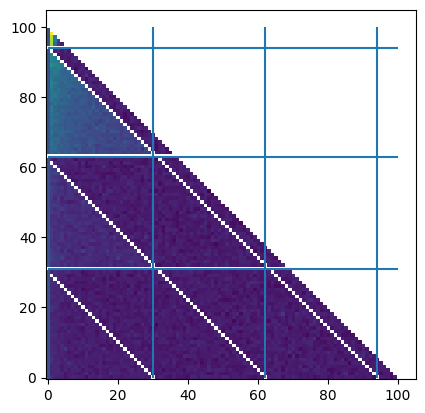

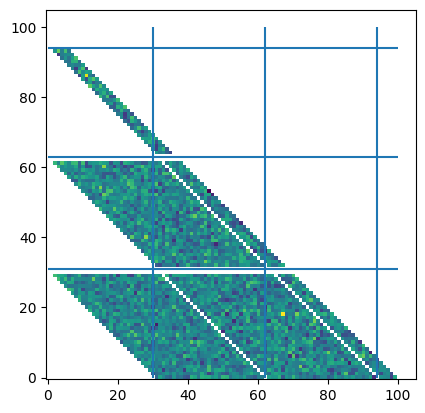

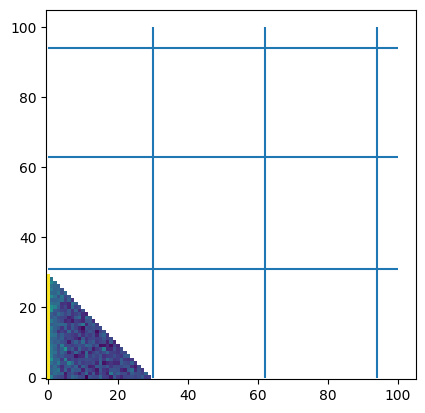

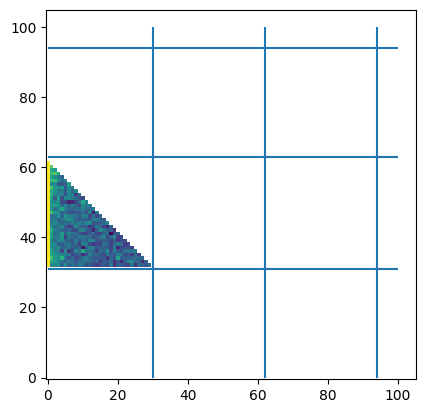

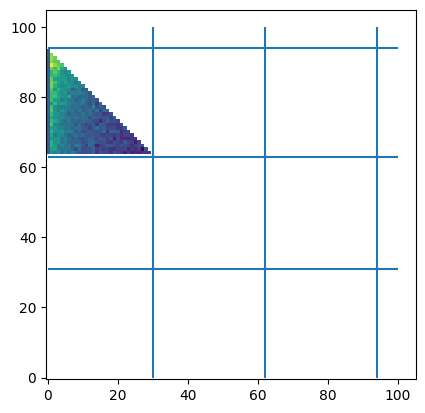

In [132]:

plt.figure()
plt.imshow(ttc_turned,origin='lower')
plt.hlines([problematic_pixel+1,problematic_pixel2+1,problematic_pixel3],0,100)
plt.vlines([problematic_pixel,problematic_pixel2,problematic_pixel3],0,100)



plt.figure()
plt.imshow(ttc_turned_rest,origin='lower')
plt.hlines([problematic_pixel+1,problematic_pixel2+1,problematic_pixel3],0,100)
plt.vlines([problematic_pixel,problematic_pixel2,problematic_pixel3],0,100)



plt.figure()
plt.imshow(ttc_turned_lq,origin='lower')
plt.hlines([problematic_pixel+1,problematic_pixel2+1,problematic_pixel3],0,100)
plt.vlines([problematic_pixel,problematic_pixel2,problematic_pixel3],0,100)



plt.figure()
plt.imshow(ttc_turned_mq,origin='lower')
plt.hlines([problematic_pixel+1,problematic_pixel2+1,problematic_pixel3],0,100)
plt.vlines([problematic_pixel,problematic_pixel2,problematic_pixel3],0,100)




plt.figure()
plt.imshow(ttc_turned_hq,origin='lower')
plt.hlines([problematic_pixel+1,problematic_pixel2+1,problematic_pixel3],0,100)
plt.vlines([problematic_pixel,problematic_pixel2,problematic_pixel3],0,100)





/tmp/ipykernel_40743/2942504231.py:3: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(ttc_turned_lq[:,cut_pixel:problematic_pixel],axis=1))
/tmp/ipykernel_40743/2942504231.py:4: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(ttc_turned_mq[:,cut_pixel:problematic_pixel],axis=1))
/tmp/ipykernel_40743/2942504231.py:5: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(ttc_turned_hq[:,cut_pixel:problematic_pixel],axis=1))
/tmp/ipykernel_40743/2942504231.py:6: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(ttc_turned_rest[:,cut_pixel:problematic_pixel],axis=1))
/tmp/ipykernel_40743/2942504231.py:7: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(ttc_turned[:,cut_pixel:problematic_pixel],axis=1))
/tmp/ipykernel_40743/2942504231.py:26: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(ttc_turned_corrected[:,cut_pixel:problematic_pixel],axis=1))


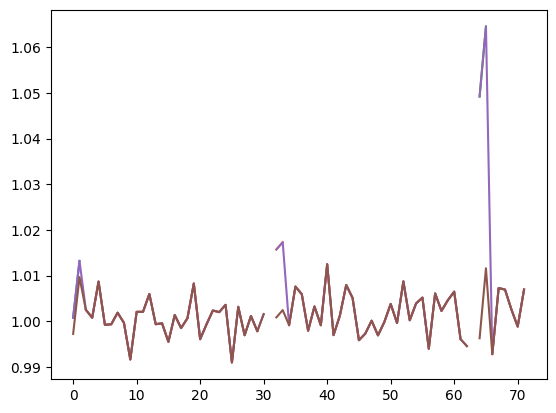

In [137]:
cut_pixel=28
plt.figure()
plt.plot(np.nanmean(ttc_turned_lq[:,cut_pixel:problematic_pixel],axis=1))
plt.plot(np.nanmean(ttc_turned_mq[:,cut_pixel:problematic_pixel],axis=1))
plt.plot(np.nanmean(ttc_turned_hq[:,cut_pixel:problematic_pixel],axis=1))
plt.plot(np.nanmean(ttc_turned_rest[:,cut_pixel:problematic_pixel],axis=1))
plt.plot(np.nanmean(ttc_turned[:,cut_pixel:problematic_pixel],axis=1))


baseline_lowerquadrant=np.nanmean(ttc_turned_lq[:,cut_pixel:problematic_pixel])
baseline_middlequadrant=np.nanmean(ttc_turned_mq[:,cut_pixel:problematic_pixel])
baseline_upperquadrant=np.nanmean(ttc_turned_hq[:,cut_pixel:problematic_pixel])
baseline_remaining=np.nanmean(ttc_turned_rest[:,cut_pixel:problematic_pixel])

baseline_corrected_ttc=ave_ttc.copy()

baseline_corrected_ttc[:problematic_pixel,:problematic_pixel]+=-baseline_lowerquadrant+baseline_remaining
baseline_corrected_ttc[problematic_pixel+1:problematic_pixel2,problematic_pixel+1:problematic_pixel2]+= -baseline_middlequadrant+baseline_remaining
baseline_corrected_ttc[problematic_pixel2+1:problematic_pixel3,problematic_pixel2+1:problematic_pixel3]+= -baseline_upperquadrant+baseline_remaining

ttc_turned_corrected=np.zeros([100,100])*np.nan

for i in range(100):
    ttc_turned_corrected[i,:len(baseline_corrected_ttc[i,i:])]=baseline_corrected_ttc[i,i:]

plt.plot(np.nanmean(ttc_turned_corrected[:,cut_pixel:problematic_pixel],axis=1))


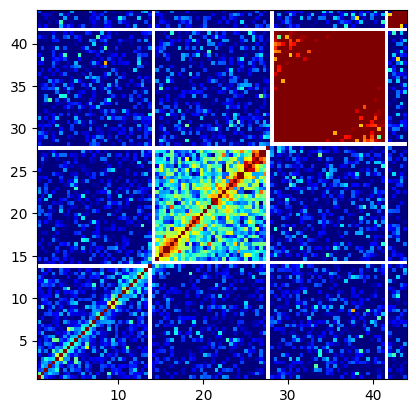

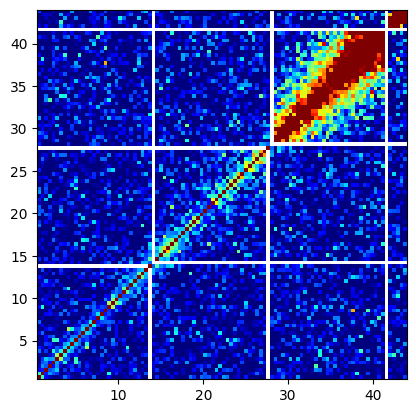

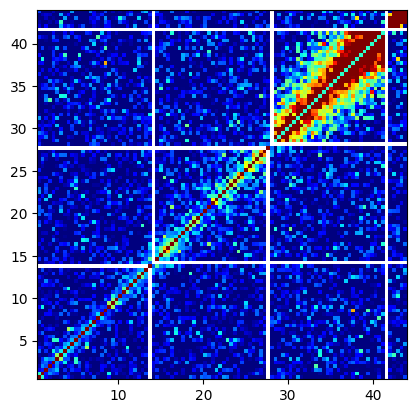

In [138]:
plt.figure()
plt.imshow(ave_ttc,origin='lower',cmap='jet',
        vmin=1,vmax=1.05,extent=(t_delay,t_delay*totframes,t_delay,t_delay*totframes),interpolation='none')
plt.figure()
plt.imshow(ave_ttc_baselinecorrected,origin='lower',cmap='jet',
        vmin=1,vmax=1.05,extent=(t_delay,t_delay*totframes,t_delay,t_delay*totframes),interpolation='none')
    
plt.figure()
plt.imshow(baseline_corrected_ttc,origin='lower',cmap='jet',
        vmin=1,vmax=1.05,extent=(t_delay,t_delay*totframes,t_delay,t_delay*totframes),interpolation='none')
    
